### 앙상블(Ensemble)
- 여러개의 분류모델을 조합해서 더 나은 성능을 내는 방법

##### RandomForest
- 의사결정나무를 bagging(단일모델을 조합)해서 예측을 실행하는 모델

In [10]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(5)

In [11]:
# 손글씨 데이터
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target

In [12]:
# 의사결정 나무를 이용한 교차검증(10) 10번 실시 
cv_scores = []
for _ in range(10):
    scores = cross_val_score(
                    DecisionTreeClassifier(),
                    features,
                    labels,
                    cv=10,
                    scoring='accuracy'
            )
    cv_scores.append(scores.mean())

cv_scores

[0.8280229671011794,
 0.8235630043451273,
 0.8224674115456239,
 0.8235692116697703,
 0.8341464928615766,
 0.8185692116697704,
 0.8241247672253259,
 0.8180136561142148,
 0.8235630043451272,
 0.8258038485412786]

In [13]:
# RandomForest를 이용한 교차검증(10) 10번 실시
cv_scores = []
for _ in range(10):
    scores = cross_val_score(
                    RandomForestClassifier(),
                    features,
                    labels,
                    cv=10,
                    scoring='accuracy'
            )
    cv_scores.append(scores.mean())

cv_scores

[0.9526939788950962,
 0.9487957790192427,
 0.9510211049037863,
 0.9549286157666046,
 0.9471322160148976,
 0.9487988826815641,
 0.952122905027933,
 0.9454531346989447,
 0.9460180012414648,
 0.9471322160148976]

---
#### 교차 검증 함수 만들기

In [14]:
# 교차검증을 10번 실행하여 평균 정확도를 구하는 함수

def cross_validation(classifier, feature, label):
    cv_scores = []
    for _ in range(10):
        scores = cross_val_score(
                        classifier,
                        feature,
                        label,
                        cv=10,
                        scoring='accuracy'
                )
        cv_scores.append(scores.mean())

    return cv_scores

In [16]:
dt_cv_scores = cross_validation(DecisionTreeClassifier(), features, labels)
dt_cv_scores

[0.8274705152079453,
 0.8336064556176288,
 0.8347020484171322,
 0.8191216635630043,
 0.8257976412166356,
 0.8291495965238982,
 0.8263531967721912,
 0.8241402855369337,
 0.8258007448789572,
 0.8246648044692737]

In [18]:
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)
rf_cv_scores

[0.9521384233395406,
 0.9488050900062073,
 0.9465735567970205,
 0.9515797641216635,
 0.9471260086902544,
 0.9482495344506517,
 0.947687771570453,
 0.947687771570453,
 0.9449068901303537,
 0.9504655493482309]

#### 랜덤포레스트와 의사결정나무의 정확도 시각화

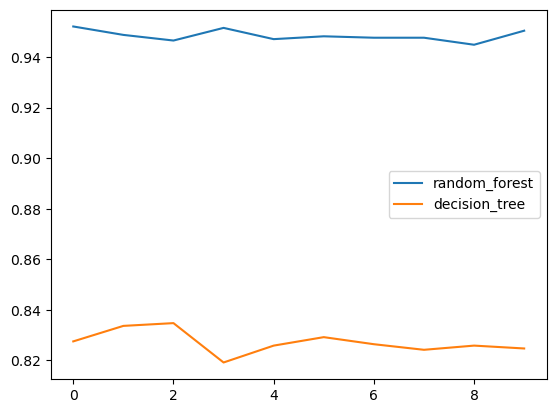

In [21]:
cv_list = {
    'random_forest' : rf_cv_scores,
    'decision_tree' : dt_cv_scores
}
df = pd.DataFrame(cv_list)
df.plot()
plt.show()

In [23]:
# 각 모델의 정확도
print(f"Decision Tree : {np.mean(dt_cv_scores)}")
print(f"Random Forest : {np.mean(rf_cv_scores)}")

Decision Tree : 0.82708069522036
Random Forest : 0.9485220360024827


---
### 보팅(Voting) 앙상블
: 단일 모델들을 앙상블하여 더 나은 예측을 하는 모델 생성

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

In [25]:
# 손글씨 데이터
train_data, test_data, train_target, test_target = \
                                train_test_split(
                                    features, 
                                    labels,
                                    test_size=0.2,
                                    stratify=labels
                                )

### 단일모델

In [26]:
# 의사결정 나무
dtree = DecisionTreeClassifier()
dtree.fit(train_data, train_target)

DecisionTreeClassifier()

In [27]:
# KNN
knn = KNeighborsClassifier()
knn.fit(train_data, train_target)

KNeighborsClassifier()

In [28]:
# SVC
svc = SVC()
svc.fit(train_data, train_target)

SVC()

In [31]:
# 정확도 : Train Data
print("decition tree:", dtree.score(train_data, train_target))
print("KNN          :", knn.score(train_data, train_target))
print("SVC          :", svc.score(train_data, train_target))

decition tree: 1.0
KNN          : 0.988865692414753
SVC          : 0.9965205288796103


In [ ]:
# 정확도 : Test Data
print("decition tree:", dtree.score(test_data, test_target))
print("KNN          :", knn.score(test_data, test_target))
print("SVC          :", svc.score(test_data, test_target))

decition tree: 0.8638888888888889
KNN          : 0.9944444444444445
SVC          : 0.9916666666666667


#### 하드 보팅
: 각각의 모델들의 예측값들을 모아 가장 많은 득표를 받은 예측값으로 최종 결론을 낸다. 

In [36]:
voting_clf = VotingClassifier(
                estimators=[('decision tree', dtree), ('knn', knn), ('svc', svc)],
                weights=[1,1,1],
                voting='hard' 
)
voting_clf.fit(train_data, train_target)

VotingClassifier(estimators=[('decision tree', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()), ('svc', SVC())],
                 weights=[1, 1, 1])

In [37]:
print("Training:", voting_clf.score(train_data, train_target))
print("Test    :", voting_clf.score(test_data, test_target))

Training: 0.9979123173277662
Test    : 0.9916666666666667


#### 소프트 보팅
: 소프트보팅은 각각 분류 모델을 활용하여 모든 분류값들의 확률들을 더해서 가장 높은 점수를 획득한 분류값으로 최종 결론을 내는 방식 

In [38]:
# 소프트보팅은 확률이 필요하므로 SVC에 확률 기능을 추가 
svc = SVC(probability=True)

In [39]:
voting_clf = VotingClassifier(
                estimators=[('decision tree', dtree), ('knn', knn), ('svc', svc)],
                weights=[1,1,1],
                voting='soft' 
)
voting_clf.fit(train_data, train_target)

VotingClassifier(estimators=[('decision tree', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft', weights=[1, 1, 1])

In [40]:
print("Training:", voting_clf.score(train_data, train_target))
print("Test    :", voting_clf.score(test_data, test_target))

Training: 0.9993041057759221
Test    : 0.9916666666666667
